In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load parquet file
df = pd.read_parquet("../data/events_history.parquet")
print(f"Loaded {len(df):,} rows")

# Basic info
display(df.head())
print(df.info())
print("\nUnique snapshot dates:", df['snapshot_date'].nunique())
print("Date range:", df['snapshot_date'].min(), "→", df['snapshot_date'].max())

# Convert event date to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

Loaded 33,222 rows


,id,name,url,type,locale,date,time,status,onsale_date,offsale_date,...,artist,artist_id,segment,genre,subgenre,family,min_price,max_price,currency,snapshot_date
0,rZ7HnEZ1AfAbON,Ticket for you + 1 for ALL 2025 shows!,https://www.ticketweb.com/event/ticket-for-you...,event,en-us,2025-01-09,08:00:00,offsale,2025-01-09T13:35:00Z,2025-02-01T05:55:00Z,...,None,None,Music,World,World,False,199.00,199.00,USD,2025-11-03
1,G5dVZbbwUsOXz,Abono Temporada NY Jazz All Stars 2025,https://www.ticketmaster.com.mx/abono-temporad...,event,en-us,2025-09-06,20:30:00,onsale,2025-02-17T19:00:00Z,2025-11-23T02:30:00Z,...,None,None,Music,Jazz,Jazz,False,NaN,NaN,None,2025-11-03
2,ZFwVzcymWZ17keas,SYLVIE (USA) IN RESIDENCE AT THE ELTHAM,https://www.moshtix.com.au/v2/event/sylvie-usa...,event,en-us,2025-10-25,19:00:00,onsale,2025-06-18T20:30:00Z,2025-11-08T05:00:00Z,...,Sylvie,K8vZ917hjk7,Music,Rock,Indie Rock,False,NaN,NaN,None,2025-11-03
3,rZ7HnEZ1Af_6QK,MOBWEEN 3 NIGHT PASS - Acid Mothers Temple (10...,https://www.ticketweb.com/event/mobween-3-nigh...,event,en-us,2025-10-30,20:00:00,offsale,2025-10-27T22:00:00Z,2025-10-31T01:00:00Z,...,Widespread Panic,K8vZ91713Gf,Music,Alternative,Alternative Rock,False,49.51,49.51,USD,2025-11-03
4,rZ7HnEZ1AfbKPK,"Vinyl Weekend Pass (4 Rooms, 8+ Artists)",https://www.ticketweb.com/event/vinyl-weekend-...,event,en-us,2025-10-31,22:00:00,offsale,2025-10-10T16:00:00Z,2025-11-02T07:00:00Z,...,None,None,Music,Other,None,False,33.95,33.95,USD,2025-11-03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33222 entries, 0 to 33221
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             33222 non-null  object 
 1   name           33222 non-null  object 
 2   url            33222 non-null  object 
 3   type           33222 non-null  object 
 4   locale         33222 non-null  object 
 5   date           33222 non-null  object 
 6   time           33034 non-null  object 
 7   status         33222 non-null  object 
 8   onsale_date    33017 non-null  object 
 9   offsale_date   33004 non-null  object 
 10  venue          32542 non-null  object 
 11  venue_id       33133 non-null  object 
 12  city           32996 non-null  object 
 13  state          24609 non-null  object 
 14  country        33094 non-null  object 
 15  venue_lat      32737 non-null  object 
 16  venue_lon      32727 non-null  object 
 17  artist         28298 non-null  object 
 18  artist

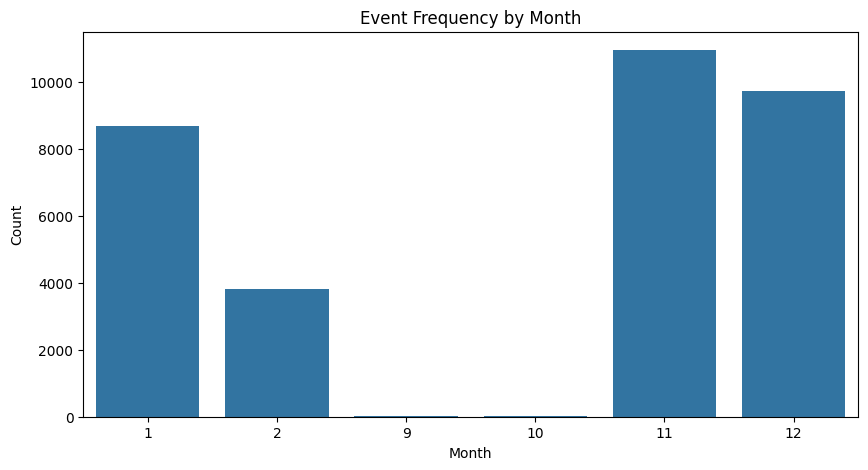

In [15]:
#Event frequency by month
plt.figure(figsize=(10,5))
sns.countplot(x='month', data=df, order=sorted(df['month'].dropna().unique()))
plt.title('Event Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

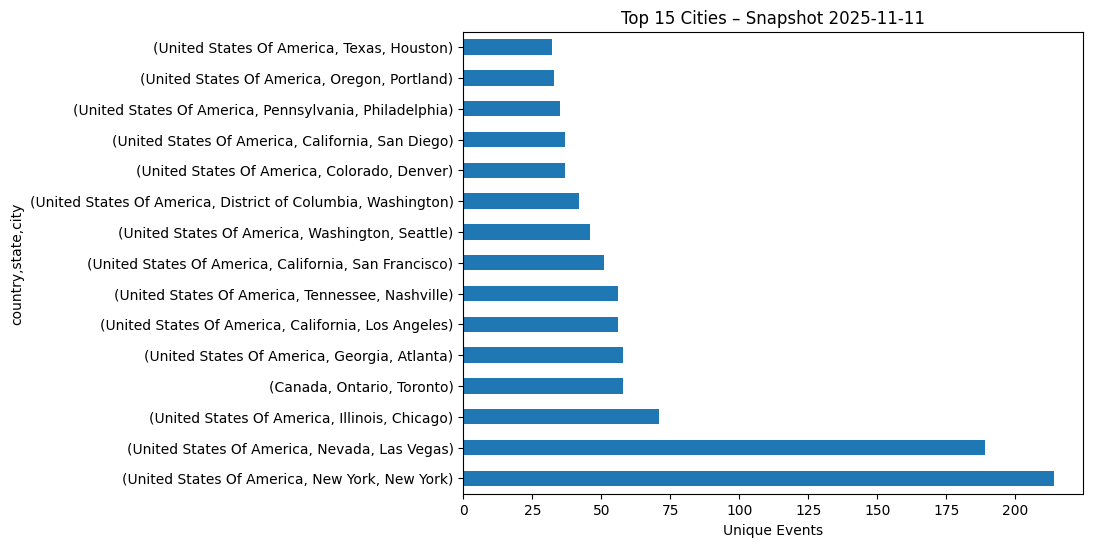

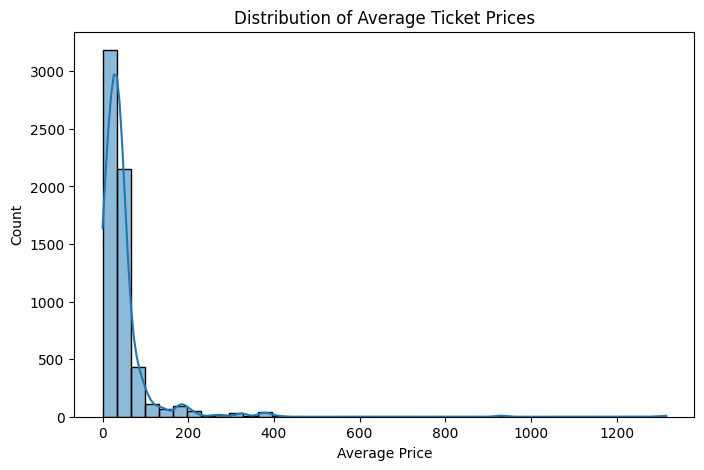

In [16]:
# Top 15 Cities by event count (latest snapshot)
latest_date = df['snapshot_date'].max()
latest_df = df[df['snapshot_date'] == latest_date]

top_cities = (
    latest_df.groupby(['country','state','city'])['id']
    .nunique()
    .sort_values(ascending=False)
    .head(15)
)
top_cities.plot(kind='barh', figsize=(8,6), title=f"Top 15 Cities – Snapshot {latest_date}")
plt.xlabel("Unique Events")
plt.show()

# Price range summary 
price_cols = ['min_price', 'max_price']
if df[price_cols].notna().any().any():
    df['avg_price'] = df[['min_price','max_price']].mean(axis=1)
    plt.figure(figsize=(8,5))
    sns.histplot(df['avg_price'].dropna(), bins=40, kde=True)
    plt.title("Distribution of Average Ticket Prices")
    plt.xlabel("Average Price")
    plt.show()
else:
    print("⚠️ No price data available in this snapshot.")


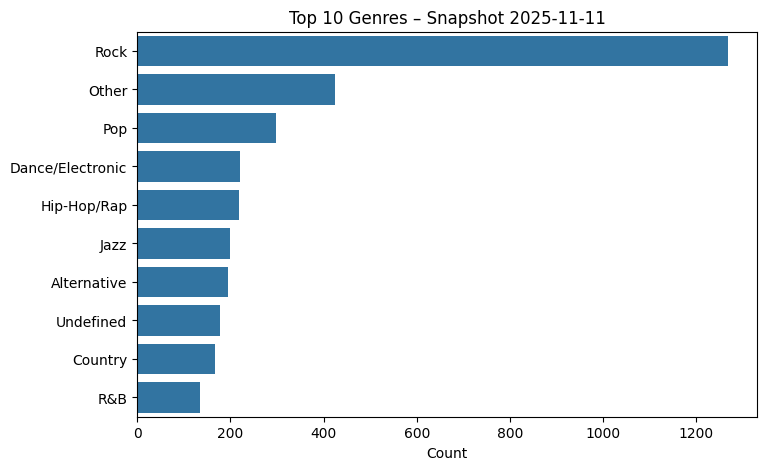

In [17]:
# Top genres
top_genres = (
    latest_df['genre']
    .value_counts()
    .head(10)
    .rename_axis('genre')
    .reset_index(name='count')
)
plt.figure(figsize=(8,5))
sns.barplot(data=top_genres, y='genre', x='count')
plt.title(f"Top 10 Genres – Snapshot {latest_date}")
plt.xlabel("Count")
plt.ylabel("")
plt.show()

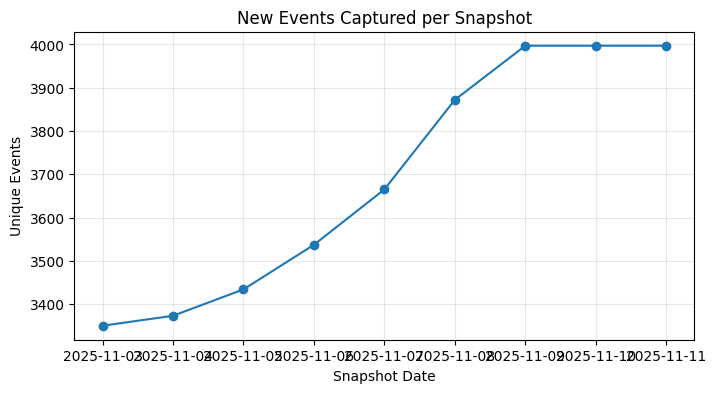

In [18]:
# Growth over time (how many new events appear each snapshot)
daily_counts = df.groupby('snapshot_date')['id'].nunique().sort_index()
plt.figure(figsize=(8,4))
daily_counts.plot(marker='o')
plt.title("New Events Captured per Snapshot")
plt.xlabel("Snapshot Date")
plt.ylabel("Unique Events")
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# Quick cross-tab: events per country
country_counts = df.groupby('country')['id'].nunique().sort_values(ascending=False)
print(country_counts.head(20))

country
United States Of America    5588
Great Britain               1630
Canada                       447
Turkey                       332
Australia                    271
Ireland                      169
Netherlands                  125
Poland                       100
Germany                       92
Mexico                        89
Belgium                       82
Denmark                       53
New Zealand                   52
Czech Republic                37
Switzerland                   34
Israel                        31
Spain                         23
Singapore                     19
Austria                       17
Sweden                        13
Name: id, dtype: int64
